## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos un cromosoma como una lista de tamaño N
# donde N es el número de slots temporales disponibles
# El ID de la operación ocupará la posición del slot temporal o 0 si no se ha asignado
# El cromosoma se codifica como una lista de enteros
# Con separadores representados por caracteres especiales, siendo 'A' el separador de quirófanos
# y 'B' el separador de días
def cromosomaAleatorio(tiempos, quirofanos, dias, actos_pendientes):
    actos = actos_pendientes.copy()
    cromosoma = []
    # Generamos un cromosoma aleatorio
    for i in range(dias):
        for j in range(quirofanos):
            # Seleccionamos un numero de intervenciones aleatorio para el slot
            num_intervenciones = random.randint(1, tiempos)
            if num_intervenciones > len(actos):
                num_intervenciones = len(actos)
            # Seleccionamos las intervenciones aleatorias
            intervenciones = random.choices(actos, k= num_intervenciones)
            # Las añadimos al cromosoma
            for intervencion in intervenciones:
                cromosoma.append(intervencion.getId())
            actos = [acto for acto in actos if acto not in intervenciones]
            # Añadimos un separador de quirófanos
            cromosoma.append('A')
        # Añadimos un separador de días
        cromosoma.append('B')
    return cromosoma

In [4]:
# Definimos al individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
# Variables globales
# Definimos la función de fitness
def evaluar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
    if not validar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
        return distance(individual, tiempos, ventana, actos_pendientes),
    # Calculamos el fitness como la suma de las ponderaciones de los actos quirúrgicos
    fitness = 0
    tiempo_quirofano = 0
    # Calculamos el fitness
    for i in range(len(individual)):
        if individual[i] != 'A' and individual[i] != 'B':
            fitness += actos_pendientes[individual[i]].getPrioridad()
            tiempo_quirofano += actos_pendientes[individual[i]].getDuracion()
    # Calculamos el tiempo de uso de quirófano
    tiempo_quirofano = tiempo_quirofano / (quirofanos * dias)
    return 1/(fitness*tiempo_quirofano),

# Definimos la función de validez
def validar(individual, tiempos, quirofanos, dias, actos_pendientes,ventana):
    # Comprobamos que la duración de las intervenciones no supera el tiempo disponible
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        tiempo_quirofano += math.ceil(actos_pendientes[elemento].getDuracion() / ventana)
        if tiempo_quirofano > tiempos:
            return False
    return True

def distance(individual,tiempos,ventana,actos_pendientes):
    # Calculamos la distancia entre los actos quirúrgicos
    dist = 0
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        tiempo_quirofano += math.ceil(actos_pendientes[elemento].getDuracion() / ventana)
        if tiempo_quirofano > tiempos:
            dist += 1
    return dist


In [6]:
def cruce(ind1, ind2):
    # Obtenemos una copia de los padres
    hijo1 = ind1.copy()
    hijo2 = ind2.copy()
    padre1 = ind1.copy()
    padre2 = ind2.copy()
    # Eliminamos los separadores de los padres
    padre1 = [i for i in ind1 if i!='A' and i!='B']
    padre2 = [i for i in ind2 if i!='A' and i!='B']
    # Selecccionamos dos puntos de cruces aleatorios
    punto1 = random.randint(0, len(ind1)-1)
    while ind1[punto1] == 'A' and ind1[punto1] == 'B':
        punto1 = random.randint(0, len(ind1)-1)
    punto2 = random.randint(0, len(ind1)-1)
    while ind1[punto2] == 'A' and ind1[punto2] == 'B' and punto2 == punto1:
        punto2 = random.randint(0, len(ind1)-1)
    punto3 = random.randint(0, len(ind2)-1)
    while ind2[punto3] == 'A' and ind2[punto3] == 'B':
        punto3 = random.randint(0, len(ind2)-1)
    punto4 = random.randint(0, len(ind2)-1)
    while ind2[punto4] == 'A' and ind2[punto4] == 'B' and punto4 == punto3:
        punto4 = random.randint(0, len(ind2)-1)
    # Añadimos los genes del padre 2 al hijo 1 hasta la región de cruce
    if punto1>punto2:
        punto = punto1
        punto1 = punto2
        punto2 = punto
    if punto3>punto4:
        punto = punto3
        punto3 = punto4
        punto4 = punto
    for i in range(len(hijo1)):
        if i < punto1 or i > punto2:
            if hijo1[i] == 'A' or hijo1[i] == 'B':
                continue
            elif len(padre2) == 0:
                break
            hijo1[i] = padre2.pop(0)
    # Añadimos los genes del padre 1 al hijo 2 hasta la región de cruce
    for i in range(len(hijo2)):
        if i < punto3 or i > punto4:
            if hijo2[i] == 'A' or hijo2[i] == 'B':
                continue
            elif len(padre1) == 0:
                break
            hijo2[i] = padre1.pop(0)
    return hijo1, hijo2
def mutacion(individual):
    # Calculamos los índices posibles de intercambio
    indices = [i for i in range(len(individual)) if individual[i] != 'A' and individual[i] != 'B']
    # Seleccionamos dos índices aleatorios
    indices = random.choices(indices, k=2)
    # Intercambiamos los valores
    individual[indices[0]], individual[indices[1]] = individual[indices[1]], individual[indices[0]]
    return individual

In [7]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes,ventana=30)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selRoulette)

In [8]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean) 
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

In [9]:
# Definimos el algoritmo genético
def algoritmo_genetico(tamano_poblacion, probabilidad_cruce, probabilidad_mutacion, numero_generaciones):
    # Generamos la población inicial
    poblacion = toolbox.population(n=tamano_poblacion)
    # Evaluamos la población
    fitnesses = list(map(toolbox.evaluate, poblacion))
    for ind, fit in zip(poblacion, fitnesses):
        ind.fitness.values = fit
    # Inicializamos las estadísticas
    record = stats.compile(poblacion)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + (stats.fields if stats else [])
    # Guardamos las estadísticas
    logbook.record(gen=0, evals=len(poblacion), **record)
    print(logbook.stream)
    # Iniciamos contador de generaciones sin mejora
    contador = 0
    hof = tools.HallOfFame(1)
    hof.update(poblacion)
    # Ejecutamos el algoritmo genético
    for g in range(1, numero_generaciones):
        # Seleccionamos a la población
        poblacion = toolbox.select(poblacion, len(poblacion))
        # Clonamos a los individuos
        hijos = list(map(toolbox.clone, poblacion))
        # Aplicamos el cruce
        for hijo1, hijo2 in zip(hijos[::2], hijos[1::2]):
            if random.random() < probabilidad_cruce:
                toolbox.mate(hijo1, hijo2)
                del hijo1.fitness.values
                del hijo2.fitness.values
        # Aplicamos la mutación
        for hijo in hijos:
            if random.random() < probabilidad_mutacion:
                toolbox.mutate(hijo)
                del hijo.fitness.values
        # Evaluamos a los individuos con fitness inválido
        invalid_ind = [ind for ind in hijos if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Reemplazamos a la población
        poblacion[:] = hijos
        # Guardamos las estadísticas
        record = stats.compile(poblacion)
        logbook.record(gen=g, evals=len(poblacion), **record)
        print(logbook.stream)
        # Comprobamos si el mejor individuo ha mejorado
        if hof[0].fitness.values > record['min']:
            contador = 0
        else:
            contador += 1
        hof.update(poblacion)
        # Si no ha mejorado en 50 generaciones, paramos
        if contador == 50:
            break
    return poblacion, logbook, hof

In [10]:
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(tamano_poblacion=200, probabilidad_cruce=0.8, probabilidad_mutacion=0.2, numero_generaciones=1000)

gen	evals	avg  	std    	min	max
0  	200  	55.76	8.83699	31 	76 
1  	200  	57.525	8.97827	31 	76 
2  	200  	58.69 	8.5606 	36 	76 
3  	200  	60.485	8.61103	40 	76 
4  	200  	61.22 	8.34096	42 	77 
5  	200  	63.185	8.20492	42 	78 
6  	200  	64.805	7.57872	42 	77 
7  	200  	65.005	7.67561	42 	77 
8  	200  	65.51 	6.73572	49 	78 
9  	200  	65.315	6.70491	49 	77 
10 	200  	66.345	6.70045	49 	77 
11 	200  	66.97 	6.59159	52 	78 
12 	200  	68    	6.77569	52 	80 
13 	200  	68.575	6.54938	56 	78 
14 	200  	68.845	6.66941	56 	78 
15 	200  	69.56 	6.71092	57 	78 
16 	200  	70.335	6.69423	58 	79 
17 	200  	71.395	6.19992	58 	80 
18 	200  	72.195	5.719  	58 	80 
19 	200  	73.125	5.50903	58 	80 
20 	200  	73.8  	5.17977	58 	80 
21 	200  	74.82 	4.402  	58 	80 
22 	200  	74.89 	4.49421	58 	80 
23 	200  	75.415	3.67325	58 	80 
24 	200  	75.425	3.33082	59 	79 
25 	200  	75.315	3.69402	57 	79 
26 	200  	74.815	4.01507	60 	81 
27 	200  	75.15 	3.66845	61 	81 
28 	200  	75.775	3.07317	61 	81 
29 	200  	75

In [11]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])

Mejor individuo:  [83, 53, 89, 6, 79, 47, 'A', 36, 50, 58, 42, 39, 77, 72, 12, 34, 92, 31, 'A', 61, 32, 30, 'A', 'B', 88, 26, 19, 98, 82, 21, 13, 51, 66, 'A', 65, 38, 99, 90, 80, 'A', 2, 87, 7, 7, 'A', 'B', 14, 63, 17, 40, 27, 74, 10, 55, 'A', 95, 67, 11, 59, 0, 60, 1, 96, 78, 93, 5, 85, 11, 67, 'A', 23, 54, 4, 25, 25, 29, 'A', 'B', 33, 48, 76, 45, 56, 20, 86, 16, 73, 57, 'A', 3, 'A', 64, 62, 81, 35, 69, 24, 'A', 'B', 43, 43, 44, 41, 68, 41, 'A', 91, 'A', 94, 'A', 'B']
Fitness del mejor:  31.0


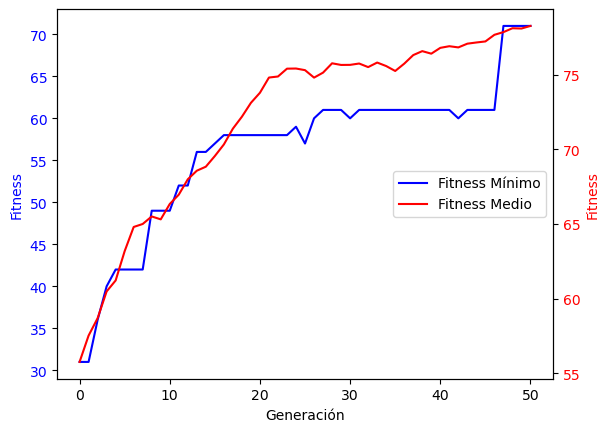

In [12]:
# Representamos el logbook
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_averages = logbook.select("avg")
fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Fitness Mínimo")
ax1.set_xlabel("Generación")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
ax2 = ax1.twinx()
line2 = ax2.plot(gen, fit_averages, "r-", label="Fitness Medio")
ax2.set_ylabel("Fitness", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")
lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")
plt.show()